In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

In [2]:
# Morgan Fingerprints

def fingerprints_matrix(mols, nBits, radius=3):
    ''' Given a list (mols) of rdkit-encoded molecules,
        return an indicator matrix of nBit Morgan fingerprints,
        i.e. each row is the morgan vector representation of a molecule
    '''
    fp_matrix = np.zeros((len(mols), nBits))
    for m, mol in enumerate(mols):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, nBits=nBits, radius=3)
        fpOn = set(fp.GetOnBits())
        fp_matrix[m] = np.array([x in fpOn for x in range(nBits)])
    return np.array(fp_matrix, dtype=int)


def partial_svd(matrix, k, keep_shape = False):
    ''' Perform rank-k partial singular value decomposition on a matrix of shape (m x n)
        and return a matrix that approximates the original
            - If keep_shape, then the output matrix is rank k and has same shape (m x n)
            - If not keep_shape, then the output matrix has smaller shape (m x k)
        # (See: https://stats.stackexchange.com/questions/107533/)
    '''
    U, s, Vt = np.linalg.svd(matrix, full_matrices=False)
    Uk = U[:,:k]
    Sk = np.diag(s[:k])
    out = Uk @ Sk
    if keep_shape:
        Vk = Vt.T[:,:k]
        out = out @ Vk.T
    return out


In [3]:
# Data normalization

def norm_unit_scale(y):
    ''' Normalize a 1D array on a 0 to 1 scale '''
    yMin, yMax = min(y), max(y)
    yRange = yMax - yMin
    return np.array([(j - yMin)/yRange for j in y]), yMin, yMax, denorm_unit_scale

def denorm_unit_scale(yNorm, yMin, yMax):
    yRange = yMax - yMin
    return np.array([j*yRange + yMin for j in yNorm])


def norm_double_unit(y):
    ''' Normalize a 1D array on a -1 to 1 scale '''
    yMin, yMax = min(y), max(y)
    halfRange = (yMax - yMin)/2
    return np.array([(j - yMin)/halfRange -1 for j in y]), yMin, yMax, denorm_double_unit

def denorm_double_unit(yNorm, yMin, yMax):
    halfRange = (yMax - yMin)/2
    return np.array([(j+1)*halfRange + yMin for j in yNorm])


def norm_z_score(y):
    ''' Normalize a 1D array by z-score '''
    mean, std = np.mean(y), np.std(y)
    return np.array([(j-mean)/std for j in y]), mean, std, denorm_z_score

def denorm_z_score(yNorm, mean, std):
    return np.array([j*std + mean for j in yNorm])


def normalize_matrix_columns(matrix, normalizer):
    return np.array([normalizer(col)[0] for col in matrix.T]).T


In [4]:
# Support functions

def train_test_split(X, y, test_size = 0.2):
    ''' Split input data X and labels y into training and testing arrays '''
    n = len(y)
    n_list = list(range(n))
    test_choice = np.random.choice(n_list, replace=False, size=int(test_size*n))
    train_choice = np.array([i for i in n_list if i not in test_choice])
    X_train = X[train_choice,:]
    X_test = X[test_choice,:]
    y_train = y[train_choice]
    y_test = y[test_choice]
    return X_train, y_train, X_test, y_test


In [5]:
# CROW Polymer Database
crow = pd.read_csv("data/crow.csv", skiprows=2, usecols = list(range(2,9))).dropna()
crow_smiles = np.array(crow['SMILES'])
crow_mols = np.array([Chem.MolFromSmiles(sm) for sm in crow_smiles])
crow_molar_mass = np.array([Descriptors.MolWt(mol) for mol in crow_mols])
crow['Molar Mass'] = crow_molar_mass

# SMILES to Morgan Fingeprints Matrix
crow_fp_128 = fingerprints_matrix(crow_mols, 128)            # largest nBits < # polymer entries 
crow_fp_2048 = fingerprints_matrix(crow_mols, 2048)          # default nBits

# Morgan Fingerprint Density?
crow_fpDensity1 = np.array([Descriptors.FpDensityMorgan1(mol) for mol in crow_mols])
crow_fpDensity2 = np.array([Descriptors.FpDensityMorgan2(mol) for mol in crow_mols])
crow_fpDensity3 = np.array([Descriptors.FpDensityMorgan3(mol) for mol in crow_mols])

# Glass Transition Temp (Labels)
crow_Tg_Kelvin = np.array(crow['Glass Trans'])
crow_Tg_Celsius = crow_Tg_Kelvin - 273 # Celsius
crow_Tg_zScore = norm_z_score(crow['Glass Trans'])[0]
crow_Tg_unit = norm_unit_scale(crow['Glass Trans'])[0]
crow_Tg_double = norm_double_unit(crow['Glass Trans'])[0]

# Other properties
crow_prop_symbols = ['Vm', '\u03C1', '\u03C3', 'Cp', 'n', 'MM']
crow_props = np.array(crow.drop(columns=['SMILES', 'Glass Trans']))
crow_props_zScore = normalize_matrix_columns(crow_props, norm_z_score)
crow_props_unit = normalize_matrix_columns(crow_props, norm_unit_scale)
crow_props_double = normalize_matrix_columns(crow_props, norm_double_unit)

# Integerize other properties for embedding
crow_density_x100 = np.array(100*crow['Density'])
crow_hildebrand_x10 = np.array(10*crow['Hildebrand'])
crow_refract_x100 = np.array(100*crow['Refract index'])
crow_props_int = np.array([np.array(crow['Molar Volume']), crow_density_x100, crow_hildebrand_x10,
                           np.array(crow['Heat Capacity']), crow_refract_x100, crow_molar_mass], dtype=int).T

crow_ones = np.array([[1]*len(crow_Tg_Kelvin)]).T
print('database imported:\tCROW Polymer Database')
crow

database imported:	CROW Polymer Database


,SMILES,Molar Volume,Density,Hildebrand,Glass Trans,Heat Capacity,Refract index,Molar Mass
2,[*]CC[*],32.9,0.85,16.7,193.0,63.0,1.48,28.054
3,[*]CC([*])C,48.8,0.86,16.2,264.0,90.0,1.47,42.081
4,[*]CC([*])CC,65.2,0.86,16.0,245.0,118.0,1.50,56.108
5,[*]CC([*])CCC,82.5,0.85,16.3,238.0,143.0,1.47,70.135
6,[*]CC([*])CCCC,97.3,0.86,16.3,223.0,178.0,1.47,84.162
...,...,...,...,...,...,...,...,...
279,[*]CC([*])SCC,82.4,1.07,22.1,266.0,165.0,1.56,88.175
280,[*]CC([*])SCCC,99.9,1.02,17.6,253.0,195.0,1.54,102.202
281,[*]CC([*])SCCCC,118.6,0.98,17.5,253.0,225.0,1.53,116.229
282,[*]CC([*])Sc1ccccc1,118.2,1.15,19.3,386.0,152.0,1.66,136.219


In [6]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    with open('crow_smiles_and_Tg_celsius.txt', 'w') as f:
        for sm, tgc in zip(crow_smiles, crow_Tg_Celsius):
            f.write(f'{sm}, {tgc}')
            f.write('\n')

In [7]:
if __name__ == "__main__" and '__file__' not in globals():
    print(fingerprints_matrix([Chem.MolFromSmiles('[*]CC[*]')], nBits=10))
    print(fingerprints_matrix([Chem.MolFromSmiles('CC')], nBits=10))

[[0 1 1 0 0 0 1 0 0 1]]
[[0 1 0 0 0 0 0 1 0 0]]


Col Min-Maxes: (24, 416) (9, 213) (123, 320) (60, 745) (122, 171) (28, 456) 

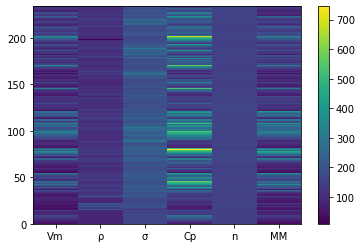

In [8]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.pcolormesh(crow_props_int)
    plt.xticks(np.arange(6)+0.5, crow_prop_symbols)
    plt.colorbar()
    
    print('Col Min-Maxes:', end=' ')
    for col in crow_props_int.T:
        print((min(col), max(col)), end=' ')

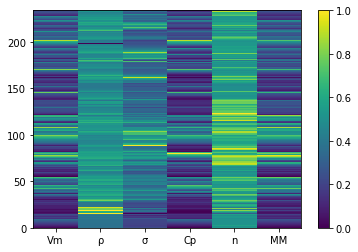

In [9]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.pcolormesh(crow_props_unit)
    plt.xticks(np.arange(6)+0.5, crow_prop_symbols)
    plt.colorbar()

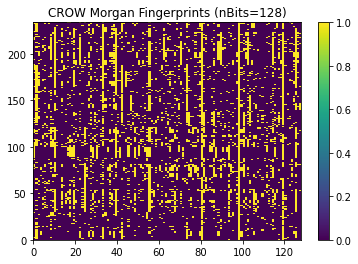

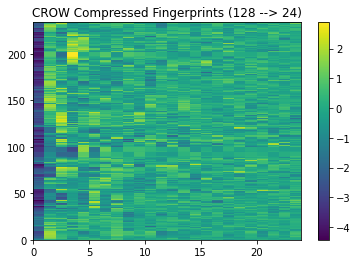

In [10]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.title('CROW Morgan Fingerprints (nBits=128)')
    plt.pcolormesh(crow_fp_128)
    plt.colorbar()
    
    plt.figure()
    plt.title('CROW Compressed Fingerprints (128 --> 24)')
    plt.pcolormesh(partial_svd(crow_fp_128, 24))
    plt.colorbar()

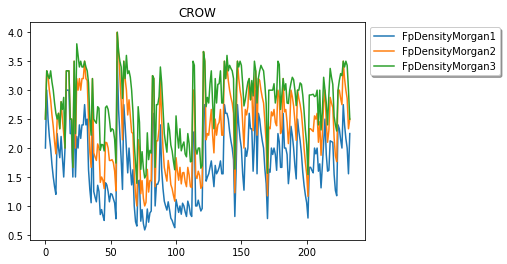

In [11]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.title('CROW')
    plt.plot(crow_fpDensity1, label='FpDensityMorgan1')
    plt.plot(crow_fpDensity2, label='FpDensityMorgan2')
    plt.plot(crow_fpDensity3, label='FpDensityMorgan3')
    plt.legend(bbox_to_anchor=(1,1), shadow=True)

[110 155 142   5  46  43 218  50 105 118 146  18]


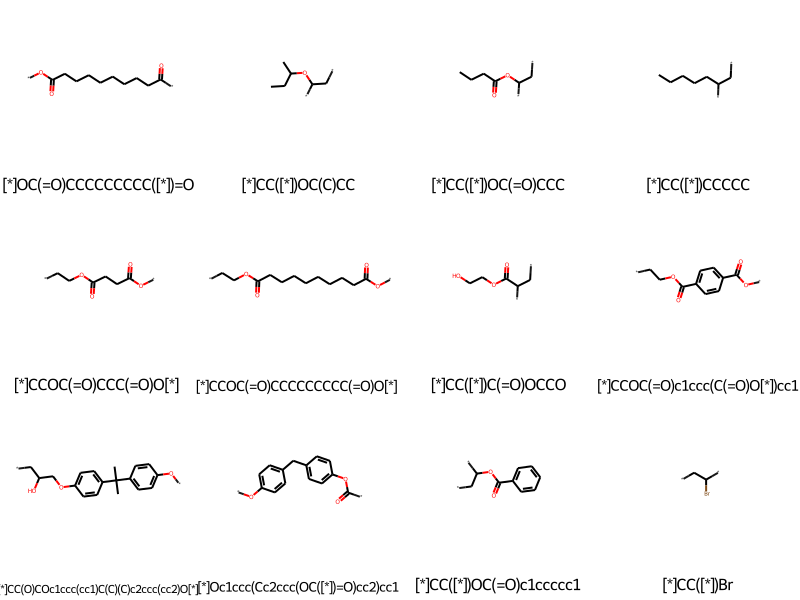

done


In [12]:
if __name__ == "__main__" and '__file__' not in globals():
    n_list = len(crow_smiles)
    some_mol_indices = np.random.choice(n_list, replace=False, size=12)
    print(some_mol_indices)
    some_mols = crow_mols[some_mol_indices]
    some_smiles = crow_smiles[some_mol_indices]
    some_drawings = Draw.MolsToGridImage(some_mols, molsPerRow=4, legends=list(some_smiles))
    display(some_drawings)
    print('done')